In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16
import keras.backend as K
from tensorflow.keras import callbacks
import tensorflow as tf

from PIL import Image

# Open image file and get the dimensions
img = Image.open('test/Carrot/1001.jpg')
shape = img.size
print(f'Image size: {shape}')
# Define parameters
batch_size = 32
num_classes = 15
input_shape = (shape[0], shape[1], 3)

# Paths to image directories
TRAIN_DIR = 'train'
TEST_DIR = 'test'
VALIDATION_DIR = 'validation'

Image size: (224, 224)


In [32]:
# Data generator with no data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generator with data augmentation
train_datagen_aug = ImageDataGenerator(rescale=1./255, # Rescale pixel values to [0, 1]
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 

train_generator_aug = train_datagen_aug.flow_from_directory(
    TRAIN_DIR, target_size=shape, batch_size=batch_size, class_mode='categorical')

# Load data with data generators
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=shape, batch_size=batch_size, class_mode='categorical')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=shape, batch_size=batch_size, class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR, target_size=shape, batch_size=batch_size, class_mode='categorical')

# Shape of data
print(f'Data shape: {train_generator[0][0].shape}')

# Number of classes
print(f'Number of classes: {len(train_generator.class_indices)}')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [30]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 10, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [59]:
# Model 1
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy",keras.metrics.Precision()])
print("Model parameters = %d" % model.count_params())
print(model.summary())

history_1 = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=callbacks_list)

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model parameters = 11635407
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 774400)            0         
                                                                 
 dropout_18 (Dropout)        (None, 774400)            0         
                                                                 
 dense_19 (Dense)            (None, 15)                11616015  
                         

In [25]:
import pandas
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

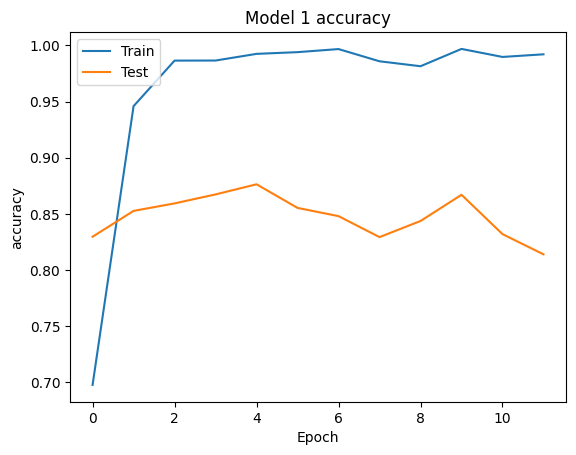

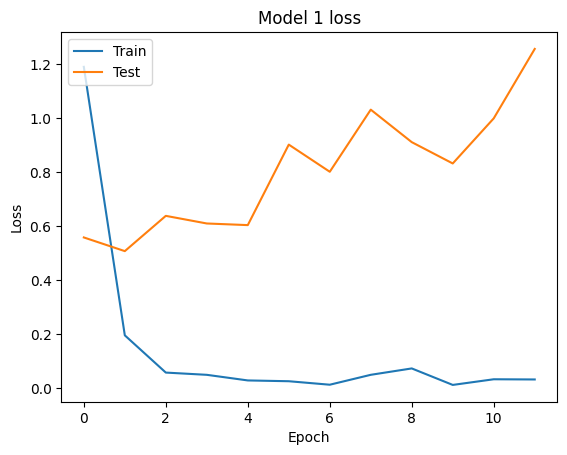

In [66]:
# Model 1 plots
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [67]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers (with them epoch takes 4 hours)
for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy",keras.metrics.Precision()])

print(model.summary())

# Train the model with  data augmentation
history_vgg16 = model.fit( train_generator_aug, epochs=30,
    validation_data=validation_generator)

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 3, 3, 512)        0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 4608)              0         
                                                                 
 dropout_19 (Dropout)        (None, 4608)              0         
                                                                 
 dense_20 (Dense)            (None, 15)                69135     
                                                                 
Total params: 14,783,823
Trainable params: 69,135
Non-trainable params: 14,714,688
____________________________________

KeyboardInterrupt: 

In [ ]:
# VGG16 plots
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [26]:
# Model 2
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy", keras.metrics.Precision()])

print(model.summary())

# Train the model with no data augmentation
history_2 = model.fit( train_generator_aug, epochs=30,
    validation_data=validation_generator, callbacks=callbacks_list)

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'Sequential' is not defined

In [ ]:
# Model 2 plots
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()